# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points or shots on cartesian or radial masks:
    - mask_type = "cartesian" : learn cartesian lines
    - mask_type = "" or not given : learn points on cartesian fourier operator
    - mask_type = "radial_CO" : learn radial CenterOut mask (i.e. radii)
    - mask_type = anything else : learn points for any type of mask (do not use this when using a cartesian mask since mask_type="" is a lot quicker)

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

/volatile/biagi/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/volatile/biagi/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/volatile/biagi/pysap-mri/mri/operators/fourier/non_cartesian.py:41: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
n = 50

n_rad = int( n/2 )
n_ang = int( n*np.pi )

#num_blocks = ( n_rad - 1 ) * n_ang + 1 # for sampling isolated points
num_blocks = n_ang # for choosing radia
#num_blocks = n_rad # for choosing circles
nb_samples = int( num_blocks * 2 / np.pi )

phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Rad, Phi = np.meshgrid( rad, phi )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=(n,n),implementation='cpu')

/volatile/biagi/pysap-mri/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-4,"gamma":1e-10}

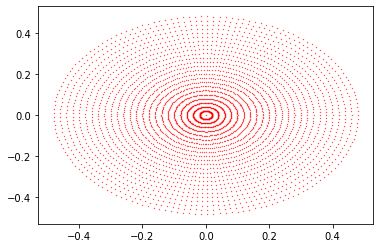

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(full_kspace_loc[:,0],full_kspace_loc[:,1],s=0.1,c='r')

### Initializing upper level
Creating images, kspace_data and updating param

In [6]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 1
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [7]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat) + 
               0.1*np.mean(u0_mat)*np.random.randn(2*(n_rad-1)*n_ang+2).view(np.complex128) 
               for u0_mat in images]

In [8]:
param["c"] = 1e-8
param["beta"] = 2e-3

In [9]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , pgtol=1e-8 ,
                    verbose=-1 , const={"sigma":0.5,"tau":1} , n_rad = n_rad)

## Learning points

In [10]:
p0 = np.random.rand(n_ang*(n_rad-1)+2)
p0[-1] = 1e-3

print("Penalty:",P(p0,param["beta"]))
print("Total energy:",E(pk = p0 , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 4.94716311724558


/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Total energy: 6.6231509631992385


In [11]:
pf,energy_upper,alphas = obj.optimize(p0=p0 , mask_type = "radial")


1 iterations: E(p)=6.551953001848572, alpha=0.9235368413965952



2 iterations: E(p)=6.482286873604048, alpha=1.4761490752005326



3 iterations: E(p)=6.1387597217842735, alpha=4.948721076476509



4 iterations: E(p)=6.046470532620075, alpha=5.052947523268573



5 iterations: E(p)=5.959664628977519, alpha=5.14956270422373



6 iterations: E(p)=5.877832769938209, alpha=5.239069956282216



7 iterations: E(p)=5.799326801899115, alpha=5.324276575114218



8 iterations: E(p)=5.72603892366541, alpha=5.402489375067447



9 iterations: E(p)=5.657218836913854, alpha=5.475068612298373



10 iterations: E(p)=5.593695889494893, alpha=5.542347800226032



11 iterations: E(p)=5.534788120544434, alpha=5.60635636988096



12 iterations: E(p)=5.479935057879896, alpha=5.6663803020061785



13 iterations: E(p)=5.428309498034926, alpha=5.721740849001822



14 iterations: E(p)=5.379129315183643, alpha=5.774282479388412



15 iterations: E(p)=5.332027486821549, alpha=5.823861541281978



16 iterations: E(

6.6231509631992385 5.116930701526689


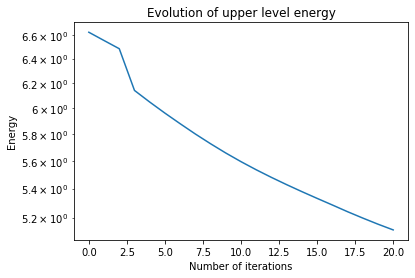

In [12]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

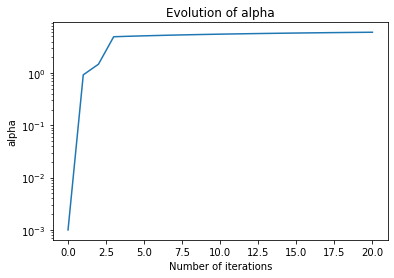

In [13]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [14]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(pf,param["beta"]))
print("Total energy:",E(pk = pf , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 3.306370646516153


/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Total energy: 5.116930701526689


In [15]:
# -- Compute mean ssim of final mask and its ceiled version --
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9078820089243496
Mean ssim ceiled mask:0.8296745475722234


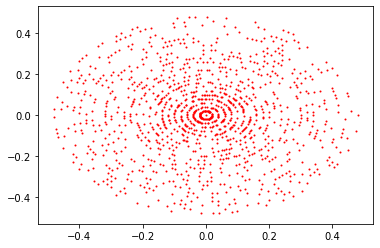

In [16]:
ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
ceiled_mask = np.array(ceiled_mask)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(ceiled_mask[:,0],ceiled_mask[:,1],s=1,c='r')

# Radial Center-Out mask

In [17]:
from UpperLevel.parametrisation import *

l0 = np.random.rand(n_ang+2)
l0[-1] = 1e-3

param["beta"]=5e-2
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , pgtol=1e-8 ,
                    verbose=-1 , const={"sigma":0.5,"tau":1} , n_rad = n_rad)

print("Penalty:",P(l0,param["beta"]))
print("Total energy:",E(lk = l0 , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial_CO" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const , n_rad = n_rad))

Penalty: 5.231273128842422
Total energy: 6.961258025057339


In [18]:
lf,energy_upper,alphas = obj.optimize(l0=l0 , mask_type = "radial_CO")


1 iterations: E(p)=6.829302176811083, alpha=0.6619915353563711



2 iterations: E(p)=6.486961724064386, alpha=3.3027374513835803




/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in subtract
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



3 iterations: E(p)=6.295600841184529, alpha=5.051292983360968



4 iterations: E(p)=6.191116844681579, alpha=7.279028599366309



5 iterations: E(p)=6.109245262021073, alpha=9.199397608937526



6 iterations: E(p)=5.9937558405650595, alpha=11.26845232065584



7 iterations: E(p)=5.908215259125431, alpha=13.225843115072246



8 iterations: E(p)=5.8327532110223625, alpha=15.486688427703603



9 iterations: E(p)=5.7150338665846, alpha=40.21771571356983



FINISHED IN 244.20295524597168 SECONDS



6.961258025057339 5.7150338665846


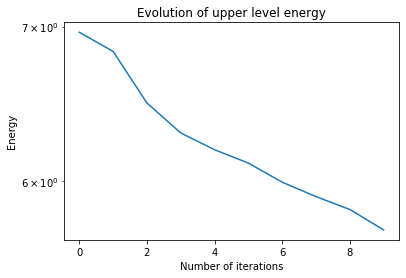

In [19]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

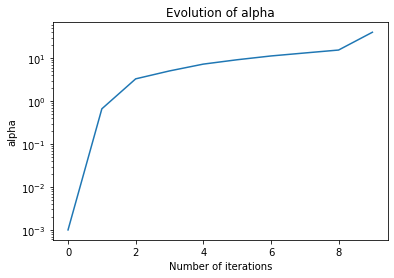

In [20]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [21]:
print("Penalty:",P(lf,param["beta"]))
print("Total energy:",E(lk = lf , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial_CO" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const , n_rad = n_rad))

Penalty: 3.5180695677819074


/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/volatile/biagi/pysap-mri/Learning-Sampling-Pattern-master/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in subtract
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Total energy: 5.7150338665846


40.21771571356983


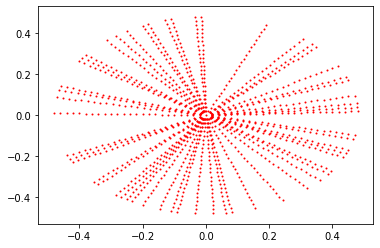

In [22]:
print(lf[-1])
pf = pradCO(lf,n_rad)
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
ceiled_mask = np.array(ceiled_mask)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(ceiled_mask[:,0],ceiled_mask[:,1],s=1,c='r')

In [23]:
print("Penalty:",P(lf,param["beta"]))
print("Total energy:",E(lk = lf , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial_CO" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const , n_rad = n_rad))

Penalty: 3.5180695677819074
Total energy: 5.7150338665846


In [24]:
# -- Compute mean ssim of final mask and its ceiled version --
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.8970883927167285
Mean ssim ceiled mask:0.8409516305890232
